# HackerEarth Machine Learning : solving citizens’ grievances

### Predict the importance

Human rights are basic rights that belong to people all around the world irrespective of race, color, sex, language, religion, political or other opinions, national or social origin, property, birth, etc. These rights include the right to life and liberty, freedom from slavery and torture, freedom of opinion and expression, the right to work and education, etc. It is meant to enable human beings to live with dignity, freedom, equality, justice, and peace. Human rights are essential to the full development of individuals and communities.

**In this problem, given dataset contains grievances of various people living in a country. Task is to predict the importance of the grievance with respect to various articles, constitutional declarations, enforcement, resources, and so on, to help the government prioritize which ones to deal with and when.**

### Data description
The dataset folder consists of the following three .csv files:

train.csv: Contains 8878 rows and 328 columns <br>
test.csv: Contains 4760 rows and 327 columns <br>
sample_submission.csv: 5 rows and 2 columns <br>

In [1]:
# Import pandas, numpy, matplotlib, seaborn libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from tabulate import tabulate

# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import FunctionTransformer

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import mord

# hide ipykernel warnings 
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False
%matplotlib inline


### Predict classification with cross validation

In [2]:
"""Function to perform cross validation and store results 
in dataframe. Cross validation looks at accuracy, precision, 
recall, f1. Returns a dataframe with results"""

def cross_val(X, y, pipe, test_metrics = ['accuracy','precision','recall','f1'], cvVal = 3,
              param_grid = {'classifier__penalty':['l1','l2','elasticnet'],
                            'classifier__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                            'classifier__l1_ratio':[0, 0.5, 0.7, 1, 1.5, 2]
                           }
             ):
    
    scoring = {'accuracy' : make_scorer(accuracy_score),
               'precision' : make_scorer(precision_score, average = 'micro'),
               'recall' : make_scorer(recall_score, average = 'micro'),
               'f1' : make_scorer(f1_score, average = 'micro')
              }
   
    if param_grid:
        gs = GridSearchCV(pipe,param_grid,cv=2,verbose = 1, n_jobs = -1)
        gs = gs.fit(X,y)    
        pipe.set_params(**gs.best_params_)

    # store results in dict
    dtreeResults = {}

    # metrics to test against
    
    for metric in test_metrics:
        # generate test results
        result = cross_validate(pipe, X, y, scoring=scoring[metric], cv=cvVal)['test_score']
        # store result in dict
        dtreeResults[metric] = result.mean()
    
    # create dataframe with resultsa
    dtreeResult = pd.DataFrame.from_dict(dtreeResults, orient='index', columns=['dTree'])

    return dtreeResult, pipe

### Dataframe information

In [3]:
def df_info(df):
    null_samples = df.isna().sum()
    null_data = np.array(
        [list(null_samples.index),
         list(str(df[i].unique()[-1])[:20]+",..." for i in df.columns),
         list(df.nunique().values),
         list(null_samples.values),
         np.round(np.array(null_samples.values)*100/df.shape[0], 2)
        ]
    )

    # view data types after conversion   
    print(tabulate(pd.DataFrame(null_data).T, headers=["Feature","example", "unique", "null", "% null"],showindex=False), "\n")

<br>

# Exploratory Data Analysis
* **In this section, data is explored for its cardinality, null values, duplicates, target class distribution etc.**
* To consider differences between train and test data [such as duplicates features, null features etc.]:
    * EDA is performed on whole data. So, train and test data is combined for EDA
    * **However, *Preprocessing* and *Prediction Model Training* is done ONLY ON TRAIN DATA**

## Data ingestion
Read train and test datasets

### Read train data
check data features and size of train data

In [4]:
# read in data from train.csv file to pandas dataframe.
df_train = pd.read_csv('dataset/train.csv',  keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)

In [5]:
df_train.head(2)

,appno,application,country.alpha2,country.name,decisiondate,docname,doctypebranch,ecli,introductiondate,issue.0,...,ccl_article=6,ccl_article=7,ccl_article=8,ccl_article=9,ccl_article=p1,ccl_article=p12,ccl_article=p4,ccl_article=p6,ccl_article=p7,importance
0,2052/08,MS WORD,ru,Russian Federation,NaN,CASE OF KOKOSHKINA v. RUSSIA,CHAMBER,ECLI:CE:ECHR:2009:0528JUD000205208,NaN,NaN,...,0,0,0,0,0,0,0,0,0,4
1,4728/07,MS WORD,tr,Turkey,NaN,CASE OF ÖZCAN v. TURKEY,COMMITTEE,ECLI:CE:ECHR:2018:0710JUD000472807,NaN,NaN,...,0,0,0,0,0,0,0,0,0,4


In [6]:
df_train.shape

(8878, 328)

### Check target class balance
* Target class 'importance' has 4 unique values
* Class distribution is imbalanced and skewed towards low importance cases 

<AxesSubplot:>

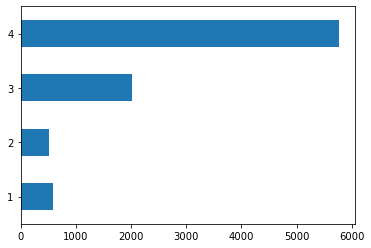

In [7]:
df_train['importance'].value_counts().plot(kind='barh')

### Read test data
Check data features and size of test data

In [8]:
# read in data from test.csv file to pandas dataframe.
df_test = pd.read_csv('dataset/test.csv',  keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)

In [9]:
df_test.head(2)

,appno,application,country.alpha2,country.name,decisiondate,docname,doctypebranch,ecli,introductiondate,issue.0,...,ccl_article=5,ccl_article=6,ccl_article=7,ccl_article=8,ccl_article=9,ccl_article=p1,ccl_article=p12,ccl_article=p4,ccl_article=p6,ccl_article=p7
0,1194/04,MS WORD,mk,North Macedonia,NaN,"CASE OF CAMINSKI v. ""THE FORMER YUGOSLAV REPUB...",COMMITTEE,ECLI:CE:ECHR:2011:0224JUD000119404,NaN,NaN,...,0,1,0,0,0,0,0,0,0,0
1,53865/11,MS WORD,ua,Ukraine,NaN,CASE OF KUSHCH v. UKRAINE,CHAMBER,ECLI:CE:ECHR:2015:1203JUD005386511,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


In [10]:
df_test.shape

(4760, 327)

## Concat train and test data to form complete dataset for EDA
* **Concat train and test data to perform EDA**
* **Drop target variable *'importance'* from train data to match number of features in both dataframes**

In [11]:
df = pd.concat([df_train.drop('importance', axis=1), df_test])

In [12]:
df.head(2)

,appno,application,country.alpha2,country.name,decisiondate,docname,doctypebranch,ecli,introductiondate,issue.0,...,ccl_article=5,ccl_article=6,ccl_article=7,ccl_article=8,ccl_article=9,ccl_article=p1,ccl_article=p12,ccl_article=p4,ccl_article=p6,ccl_article=p7
0,2052/08,MS WORD,ru,Russian Federation,NaN,CASE OF KOKOSHKINA v. RUSSIA,CHAMBER,ECLI:CE:ECHR:2009:0528JUD000205208,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
1,4728/07,MS WORD,tr,Turkey,NaN,CASE OF ÖZCAN v. TURKEY,COMMITTEE,ECLI:CE:ECHR:2018:0710JUD000472807,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


In [13]:
df.shape

(13638, 327)

### Count of Unique and null instances in features
We can locate primary key features of dataframe : **'ecli', 'itemid'**

In [14]:
df_info(df)

Feature                            example                     unique    null    % null
---------------------------------  ------------------------  --------  ------  --------
appno                              21155/18,...                 13467       0      0
application                        MS WORD,...                      1       0      0
country.alpha2                     ad,...                          46       0      0
country.name                       Andorra,...                     46       0      0
decisiondate                       20/02/2007,...                 274   12603     92.41
docname                            CASE OF VOGLREITER v,...     13201       0      0
doctypebranch                      GRANDCHAMBER,...                 3       0      0
ecli                               ECLI:CE:ECHR:2019:09,...     13638       0      0
introductiondate                   07/05/2004,...                 720   12602     92.4
issue.0                            Bankruptcy Act (no.

### find duplicate samples or features in dataset

**duplicate samples are NOT found**

In [15]:
# Check for duplicate rows
#Print the number of duplicate rows, without the original rows that were duplicated

# Check for duplicate rows for primary key "Animal ID"
print('Number of duplicate (excluding first) rows in the table is: ', df.duplicated(subset = "ecli").sum()) 

# Use "keep=False" to mark all duplicates as true, including the original rows that were duplicated.
print('Number of duplicate rows (including first) in the table is:', df[df.duplicated(subset = "ecli",keep=False)].shape[0])


Number of duplicate (excluding first) rows in the table is:  0
Number of duplicate rows (including first) in the table is: 0


**50 duplicate features are FOUND**

In [16]:
# Check for duplicate columns
#First transpose the df so columns become rows, then apply the same check as above
dfT = df.T

# Check for duplicate columns.
print("Number of duplicate (excluding first) columns in the table is: ", dfT.duplicated().sum())

#Print the number of duplicates, including the original columns that were duplicated
print("Number of duplicate (including first) columns in the table is: ",  dfT[dfT.duplicated(keep=False)].shape[0])

Number of duplicate (excluding first) columns in the table is:  50
Number of duplicate (including first) columns in the table is:  97


**Result : Duplicate columns (features) do exist**
 - **data samples** : Duplicate samples do not exist. Feature **ecli** has 13638 unique values - which is equal to number of data entries. Logically, its a primary key for the dataset. Hence, duplicacies are checked with its respect and none are found.
 - **features** : Total 97 features are invoved in duplicate entries and 50 features are duplicates of another 47 distinct features. Visualization in following cell helps to check out relations. 

### Locate Duplicate Features

In [17]:
retained_columns = dfT.drop_duplicates(keep="first").T.columns.values
duplicate_features = list(set(list(df.columns)) - set(retained_columns))
print("duplicate features",duplicate_features)

duplicate features ['paragraphs=8', 'paragraphs=P13-1', 'paragraphs=11', 'paragraphs=3', 'paragraphs=36', 'paragraphs=', 'documentcollectionid=ENG', 'paragraphs=14', 'paragraphs=12', 'kpdate', 'paragraphs=34', 'paragraphs=18', 'paragraphs=2', 'paragraphs=5', 'paragraphs=27', 'paragraphs=P7-1-1', 'paragraphs=53', 'documentcollectionid=JUDGMENTS', 'applicability=29', 'paragraphs=43', 'paragraphs=15', 'paragraphs=32', 'paragraphs=7', 'paragraphs=30', 'paragraphs=46', 'paragraphs=10', 'paragraphs=1', 'applicability=15', 'paragraphs=4', 'paragraphs=35', 'paragraphs=29', 'applicability=31', 'paragraphs=39', 'paragraphs=52', 'paragraphs=16', 'paragraphs=17', 'paragraphs=57', 'paragraphs=26', 'paragraphs=56', 'paragraphs=P12-1', 'paragraphs=19', 'paragraphs=28', 'paragraphs=38', 'paragraphs=41', 'paragraphs=37', 'paragraphs=6', 'paragraphs=25', 'paragraphs=9', 'paragraphs=33', 'paragraphs=13']


## Correlations

### Convert datatypes
* Categorical variables are retained as objects
* Integer and one hot encoded cat variables are inferred as 'int' types

In [18]:
# maintain object dtype as 'object' only
df = df.convert_dtypes(convert_string=False)

# view data types after conversion   
print(tabulate(pd.DataFrame(df.dtypes), headers=["Feature", "Data Type"]), "\n")

Feature                            Data Type
---------------------------------  -----------
appno                              object
application                        object
country.alpha2                     object
country.name                       object
decisiondate                       object
docname                            object
doctypebranch                      object
ecli                               object
introductiondate                   object
issue.0                            object
issue.1                            object
issue.10                           object
issue.11                           object
issue.12                           object
issue.13                           object
issue.14                           object
issue.15                           object
issue.16                           object
issue.17                           object
issue.18                           object
issue.19                           object
issue.2                   

<br>

# Data Quality Plan

### Observations from data
* **Few features are provided in 1 hot encoded format** : issue.{0-26}, article={27 nos}, applicability={61 nos}, ccl_article={25 nos}, paragraphs={132 nos}

### Action items
* **Drop confirm duplicate columns noticed on merged data**

### Analysis

* **NO_SIG** : Not significant towards prediction of target variable 'importance'
* **SIG** : Probable candidate feature to contribute in prediction of target variable 'importance'
* **HCR** : Very high Correlation with another feature
* **Keep** : KEEP feature
* **Drop** : DROP feature

| Features                  | Data<br>Classification| Subtype    | Description Or<br>domain significance  | Data quality issue |Solution Strategy |
|:------------------------- |:------------------ |:---------- |:-----------|:-------------- |:-------------- | 
| appno                                 | catagorical        | nominal    | application number<br><br>e.g. 53865/11|**NO_SIG**<br>13467 unique values<br>No nulls|**Drop**<br>|
| application                           | catagorical        | nominal    | software used<br><br>for lodging complaint<br>e.g. MS word|**NO_SIG**<br>1 unique value<br>no null|**Drop**<br>|
| country.alpha2                        | catagorical        | nominal    | country code<br><br>e.g. ie|**SIG**<br>46 unique countries<br>no nulls|**Keep**<br><br>one hot encode into constituent features|
| country.name                          | catagorical        | nominal    | country name<br><br>e.g. Ireland|**HCR**<br>Corr->1 with<br>'country.alpha2'|**Drop**<br>|
| decisiondate                          | numeric            | continuous<br>datetime   | date of decision|**NO_SIG**<br>92% null values|**Drop**<br>|
| docname                               | catagorical        | nominal    | name of case<br><br>e.g.CASE OF <br>EMINBEYLI v. RUSSIA|**NO_SIG**<br>name of complainant <br>and country available <br>in features 'country.name' <br>and 'parties.0'|**Drop**<br>|
| doctypebranch                         | catagorical        | Ordinal    | type of case<br><br>e.g. CHEMBER, COMMITTEE,<br>GRANDCHEMBER|**SIG**<br>represented in 1-hot<br>encoded form<br>in feature<br>'documentcollectionid=<br>{CHEMBER, COMMITTEE,<br>GRANDCHEMBER}'|**Drop**<br>|
| ecli                                  | catagorical        | nominal    | database case ID<br><br>e.g. ECLI:CE:ECHR:2015:<br>.1203JUD005386511|**NO_SIG**<br>primary key<br>no contribution<br>in prediction|**Drop**<br>|
| introductiondate                      | numeric            | continuous<br>datetime   | date of introduction|**NO_SIG**<br>92% null values|**Drop**<br>|
| itemid                                | catagorical        | nominal    | database item ID<br><br>e.g. 001-108659|**NO_SIG**<br>primary key<br>no contribution<br>in prediction|**Drop**<br>|
| judgementdate                         | numeric            | continuous<br>datetime   | date of Judgement|**SIG**<br>No null values<br>2088 unique<br>entries in<br>13638 samples|**Keep**<br><br>seperate into quarter, month,<br>year, weekday and<br>convert to categorical|
| kpdate                                | numeric            | continuous<br>datetime   | date of closure|**SIG**<br>No null values<br>2088 unique<br>entries in<br>13638 samples|**Drop**<br>Duplicate of judgementdate|
| languageisocode                       | catagorical        | nominal    | Language<br><br>e.g. ENG|**NO_SIG**<br>1 unique value<br>no null|**Drop**<br>|
| originatingbody                       | catagorical        | nominal    | Party originating<br>case<br><br>e.g. [29,1..]|**SIG**<br>13 unique value<br>no null|**Keep**<br><br>one hot encode into constituent features |
| originatingbody_name                  | catagorical        | nominal    | Name of party<br>originating<br>case<br><br>e.g. Fith Section Committee,<br>Second Section|**HCR**<br>Corr->1 with<br>'originatingbody'|**Drop**<br>|
| originatingbody_type                  | catagorical        | nominal    | Name of party<br>originating<br>case|**NO_SIG**<br>1 unique value<br>no null|**Drop**<br>|
| parties.0                             | catagorical        | nominal    | Name of party<br>filing<br>case|**NO_SIG**<br>12535 unique values<br>no null|**Drop**<br>|
| parties.1                             | catagorical        | nominal    | Name of country/s<br>against whome<br>case filed<br><br>e.g. "IRELAND", "RUSSIA"|**NO_SIG**<br>107 unique values<br>no null<br>majority of values<br>correlate with<br>'country.alpha2'|**Drop**<br>|
| parties.2                             | catagorical        | nominal    | party of body <br>from whom the<br> case originated<br><br>e.g. "IRELAND", "RUSSIA"|**NO_SIG**<br>~99% null values|**Drop**<br>|
| rank                                  | numerical        | continuous   | rank (0-10000)<br>of officials<br>rank of an official<br>increases with value|**SIG**<br>6484 unique values<br>no null|**Keep**<br><br>high cardinality feature<br>binning is necessary|
| respondent.0                          | catagorical        | nominal    | respondant to grievence<br>e.g. RUS|**HCR**<br>Corr->1 with<br>'country.alpha2'|**Drop**<br>|
| respondent.1                          | catagorical        | nominal    |respondant to grievence<br>e.g. RUS|**NO_SIG**<br>99% null values|**Drop**<br>|
| respondent.2                          | catagorical        | nominal    | respondant to grievence<br>e.g. RUS|**NO_SIG**<br>99% null values|**Drop**<br>|
| respondent.3                          | catagorical        | nominal    | respondant to grievence<br>e.g. RUS|**NO_SIG**<br>99% null values|**Drop**<br>|
| respondent.4                          | catagorical        | nominal    | respondant to grievence<br>e.g. RUS|**NO_SIG**<br>99% null values|**Drop**<br>|
| respondentOrderEng                    | catagorical        | nominal    | respondent information<br>numreic label<br>e.g. 49|**HCR**<br>Corr->1 with<br>'country.alpha2'|**Drop**<br>|
| separateopinion                       | catagorical        | nominal    |  on a case<br> e.g. {TRUE, FALSE}|**SIG**<br>No null values<br>Boolean feature|**Keep**<br><br>one hot encode into constituent features |
| sharepointid                          | catagorical        | nominal    | sharepoint ID<br><br>e.g. 359124|**NO_SIG**<br>primary key<br>no contribution<br>in prediction|**Drop**<br>|
| typedescription                       | catagorical        | nominal    | type_description {12- 19}|**SIG**<br>No null values<br>5 distinct values|**Keep**<br><br>one hot encode into constituent features |
| issue.{0-26}                          | catagorical        | nominal    | description with respect<br>to an issue<br><br>e.g. "Instruction regarding<br>the detention","Law on pre-trial<br>detention (1997-..|**NO_SIG**<br>text description<br>~99% null data in<br>most of columns|**Drop**<br>|
| article={27 numbers}                  | catagorical        | nominal    | type of article|**SIG**<br>1 hot encoded|**Keep**<br>|
| documentcollectionid=<br>CASELAW      | catagorical        | nominal    | document category=CASELAW   |**NO_SIG**<br>1 unique value<br>no null|**Drop**<br>|
| documentcollectionid=<br>JUDGMENTS    | catagorical        | nominal    | document category=JUDGEMENTS|**NO_SIG**<br>1 unique value<br>no null|**Drop**<br>|
| documentcollectionid=<br>ENG          | catagorical        | nominal    | document category=ENG|**NO_SIG**<br>1 unique value<br>no null|**Drop**<br>|
| documentcollectionid=<br>CHAMBER      | catagorical        | nominal    | document category=CHEMBERS|**SIG**<br>1 hot encoded<br>from feature<br>'doctypebranch'|**Keep**<br>|
| documentcollectionid=<br>COMMITTEE    | catagorical        | nominal    | document category=COMMITTEE|**SIG**<br>1 hot encoded<br>from feature<br>'doctypebranch'|**Keep**<br>|
| documentcollectionid=<br>GRANDCHAMBER | catagorical        | nominal    | document category=GRANDCHEMBER|**SIG**<br>1 hot encoded<br>from feature<br>'doctypebranch'|**Keep**<br>|
| applicability=<br>{61 numbers}        | catagorical        | nominal    |  applicability of case|**SIG**<br>1 hot encoded|**Keep**<br>|
| ccl_article=<br>{25 Type}             | catagorical        | nominal    | reliability of<br>CCL article type<br>e.g. {-1,0,1}|**SIG**<br>1 hot encoded|**Keep**<br><br>one hot encode into constituent features |
| paragraphs=<br>{132 numbers}          | catagorical        | nominal    | category   |**SIG**<br>1 hot encoded|**Keep**<br>|
| importance                            | catagorical        | ordinal    | Target variable<br>0-5|**SIG**<br>target variable|**Keep**<br>|


## Feature sets for preprocessing

### Insingnificant Features
Features not significant for infering target variable are dropped 

In [19]:
drop_features = ["appno", "application", "country.name",
                    "decisiondate", "docname", "doctypebranch",
                    "ecli", "introductiondate", "itemid",
                    "kpdate", "languageisocode", "originatingbody_name",
                    "originatingbody_type", "sharepointid",
                    "documentcollectionid=CASELAW", "documentcollectionid=JUDGMENTS",
                    "documentcollectionid=ENG", 
                    *df.filter(like='parties', axis=1).columns,
                    *df.filter(like='respondent', axis=1).columns,
                    *df.filter(like='issue', axis=1).columns                    
                   ]

# few columns listed to be dropped are also in duplicates. They are removed from dropped_features
drop_features = [item for item in drop_features if item not in duplicate_features]

print("drop features",drop_features)

drop features ['appno', 'application', 'country.name', 'decisiondate', 'docname', 'doctypebranch', 'ecli', 'introductiondate', 'itemid', 'languageisocode', 'originatingbody_name', 'originatingbody_type', 'sharepointid', 'documentcollectionid=CASELAW', 'parties.0', 'parties.1', 'parties.2', 'respondent.0', 'respondent.1', 'respondent.2', 'respondent.3', 'respondent.4', 'respondentOrderEng', 'issue.0', 'issue.1', 'issue.10', 'issue.11', 'issue.12', 'issue.13', 'issue.14', 'issue.15', 'issue.16', 'issue.17', 'issue.18', 'issue.19', 'issue.2', 'issue.20', 'issue.21', 'issue.22', 'issue.23', 'issue.24', 'issue.25', 'issue.26', 'issue.3', 'issue.4', 'issue.5', 'issue.6', 'issue.7', 'issue.8', 'issue.9']


### Features selected for onehot transformation 

In [20]:
oh_features = ["country.alpha2","originatingbody", "separateopinion", "typedescription",
                *df.filter(like='ccl_article', axis=1).columns
               ]

### Features selected for binning 

In [21]:
bin_features = ["rank"]

### Features selected for ordinal binning
Features comprising "year" are significant ordnial variables

In [22]:
ordinal_features = []

### datetime features

In [23]:
datetime_features = ['judgementdate']

In [24]:
for dt_col in datetime_features:
    # add new categorical features into list for onehot encoding columns
    oh_features.extend([dt_col+'_quarter', dt_col+'_weekday', dt_col+'_month'])
    ordinal_features.append(dt_col+'_year')

### Target variable

In [25]:
target_feature = 'importance'

# Preprocessing
Apply transformation to make dataframe necessary for training a model 

### Datetime feature resolution into component features

In [26]:
# Resolve each datetime entry into quarter of year, day of week, year and month
def date_transform(df_proc, datetime_columns):
    for dt_col in datetime_columns:
        df_proc.drop(list(df_proc.filter(like=dt_col+"_", axis=1).columns), axis=1, inplace=True)
        df_proc[dt_col] = pd.to_datetime(df_proc[dt_col], format="%d/%m/%Y")    
        df_proc[dt_col+'_quarter'] = df_proc[dt_col].dt.quarter
        df_proc[dt_col+'_quarter'] = df_proc[dt_col+'_quarter'].astype('object') 
        df_proc[dt_col+'_weekday'] = df_proc[dt_col].dt.weekday 
        df_proc[dt_col+'_weekday'] = df_proc[dt_col+'_weekday'].astype('object') 
        df_proc[dt_col+'_month'] = df_proc[dt_col].dt.month
        df_proc[dt_col+'_month'] = df_proc[dt_col+'_month'].astype('object')     
        df_proc[dt_col+'_year'] = df_proc[dt_col].dt.year
        # remove parent column
        df_proc.drop(dt_col,axis=1, inplace=True)
    return df_proc

### Drop features

In [27]:
def feature_drop(df, dropped_features):
    return df.drop(dropped_features, axis=1)

### Preprocess data

In [28]:
# target is present only in case of train data. For test data, target feature is not available
def preprocess_data(df, datetime_features, dropped_features, target=False):
    df = date_transform(df.copy(deep=True),datetime_features) 
    df = feature_drop(df, dropped_features)
    if target:
        X = df.drop([target], axis=1)
        y = df[target]
        return X,y
    else:
        return df

# Train classifier

### Column transformer

In [29]:
col_xform = ColumnTransformer(
    [
        ("ohe_categorical",
         OneHotEncoder(handle_unknown="ignore"),
         oh_features
        ),
        
        ("binned_numeric", 
         KBinsDiscretizer(n_bins=100, encode="onehot", strategy='uniform'),
         bin_features
        ),
        
        ("binned_categorical", 
         KBinsDiscretizer(n_bins=20, encode="ordinal", strategy='uniform'),
         ordinal_features
        ),             
    ],
    remainder="passthrough",
)

### Classifier

In [30]:
clf = LogisticRegression()
param_grid = {'classifier__penalty':['l1','l2','elasticnet'],
            'classifier__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'classifier__l1_ratio':[0, 0.5, 0.7, 1, 1.5, 2]
           }

In [31]:
# clf = mord.OrdinalRidge(alpha=0.001,
#                             fit_intercept=True,
#                             normalize=False,
#                             copy_X=True, max_iter=None,
#                             tol=0.001,
#                             solver='auto') 
# param_grid = {}

### ML pipline

In [32]:
data_pipe = Pipeline([
    ("preprocessor", col_xform),
    ("classifier", clf)])

### Prepare training data

In [33]:
# copy of test dataset
df_proc = df_train.copy(deep=True)

In [34]:
dropped_features = drop_features + duplicate_features

In [35]:
X,y = preprocess_data(df_proc, datetime_features, dropped_features, target=target_feature)
print("Input dataframe shape",df_proc.shape)
print("Input features shape", X.shape, "Target features shape", y.shape)

Input dataframe shape (8878, 328)
Input features shape (8878, 230) Target features shape (8878,)


## Train model

In [36]:
# cv results and pipe with grid searched parameters
result, train_pipe = cross_val(X, y, data_pipe, cvVal = 2, param_grid=param_grid)
result

Fitting 2 folds for each of 90 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.1min finished


,dTree
accuracy,0.853120
precision,0.852895
recall,0.853233
f1,0.853233


In [37]:
model = train_pipe.fit(X,y)

In [38]:
model.predict(X)

array([4, 4, 4, ..., 4, 3, 4], dtype=int64)

### Prepare Testing data

In [39]:
# copy of test dataset
df_out = df_test.copy(deep=True)

In [40]:
dropped_features = drop_features + duplicate_features

In [41]:
X = preprocess_data(df_out, datetime_features, dropped_features)
print("Input dataframe shape",df_out.shape)
print("Input features shape", X.shape)

Input dataframe shape (4760, 327)
Input features shape (4760, 230)


### save predictions

In [42]:
output_df = pd.DataFrame(columns=['appno','importance'])
output_df['appno'] = df_test['appno']
output_df['importance'] = model.predict(X)
output_df.to_csv("dataset/submission.csv",index=False)

# tensorflow implementation using coral-ordinal transformation

In [43]:
# # Install source package from GitHub
# !pip install --force-reinstall --no-deps git+https://github.com/ck37/coral-ordinal/

In [44]:
# import tensorflow as tf
# print("Tensorflow version", tf.__version__)

# import coral_ordinal as coral
# print("CORAL Ordinal version:", coral.__version__)

<br>
<br>
<br>
<br>

# rough work

<br>
<br>
<br>

In [45]:
# col_xform = make_column_transformer(
#         (
#          OneHotEncoder(handle_unknown="ignore"),
#          oh_features
#         ),
        
#         ( 
#          KBinsDiscretizer(n_bins=100, encode="onehot", strategy='uniform'),
#          bin_features
#         ),
        
#         ( 
#          KBinsDiscretizer(n_bins=20, encode="ordinal", strategy='uniform'),
#          ordinal_features
#         ),
#     remainder="passthrough",
# )

# df_info(pd.DataFrame(col_xform.fit_transform(X)))